In [16]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../20240503')
import DCTR


# Process Data

In [17]:
data_dir = '../../Data'
num_events = 100000


In [18]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with python scripts on NAF
X0_showered = np.load(f'{data_dir}/POWHEG_hvq/all_decays/converted_lhe_hvq_all_decays_1.npy')[:num_events]

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/Data/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
np.save(f'{data_dir}/POWHEG_hvq/all_decays/normed_lhe_hvq_all_decays_1.npy', X0_nrm)
'''
X0_nrm = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays/normed_lhe_hvq_all_decays_1.npy')[:num_events])

X0_nJets = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays/jet_multiplicity_hvq_all_decays_1.npy')[:num_events])
X0_wgt = X0_nJets[:,1]

X0_jet = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays/jet_4vectors_hvq_all_decays_1.npy'))


print(f'{np.shape(X0_showered)  = }')
print(f'{np.shape(X0_nrm)       = }')
print(f'{np.shape(X0_nJets)     = }')
print(f'{np.shape(X0_wgt)       = }')
print(f'{np.shape(X0_jet)       = }')


np.shape(X0_showered)  = (100000, 3, 9)
np.shape(X0_nrm)       = (100000, 3, 9)
np.shape(X0_nJets)     = (100000, 2)
np.shape(X0_wgt)       = (100000,)
np.shape(X0_jet)       = (100000, 20, 6)


In [20]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with python scripts on NAF
X0_filtered_showered = np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/converted_lhe_hvq_all_decays_filtered.npy')[:num_events]

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/Data/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_filtered_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
np.save(f'{data_dir}/POWHEG_hvq/all_decays_filtered/normed_lhe_hvq_all_decays_filtered.npy', X0_nrm)
'''
X0_filtered_nrm = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/normed_lhe_hvq_all_decays_filtered.npy')[:num_events])

X0_filtered_nJets = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/jet_multiplicity_hvq_all_decays_filtered.npy')[:num_events])
X0_filtered_wgt = X0_filtered_nJets[:,1]

X0_filtered_jet = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/jet_4vectors_hvq_all_decays_filtered.npy'))


print(f'{np.shape(X0_filtered_showered)  = }')
print(f'{np.shape(X0_filtered_nrm)       = }')
print(f'{np.shape(X0_filtered_nJets)     = }')
print(f'{np.shape(X0_filtered_wgt)       = }')
print(f'{np.shape(X0_filtered_jet)       = }')



np.shape(X0_filtered_showered)  = (100000, 3, 9)
np.shape(X0_filtered_nrm)       = (100000, 3, 9)
np.shape(X0_filtered_nJets)     = (100000, 2)
np.shape(X0_filtered_wgt)       = (100000,)
np.shape(X0_filtered_jet)       = (100000, 20, 6)


In [21]:
# MiNNLO | only 10k events per lhe

X1_showered = []
X1_nJets = []
X1_jet = []

for i in range(11):
    if i == 4: # probably broken, sinze size is smaller than other datasets | 0.6MB vs 2.2MB
        continue
    X1_showered.extend(np.load(f'{data_dir}/MiNNLO/showered/converted_lhe_MiNNLO_{990 + i:04d}.npy'))
    X1_nJets.extend(np.load(f'{data_dir}/MiNNLO/showered/jet_multiplicity_MiNNLO_{990 + i:04d}.npy'))
    X1_jet.extend(np.load(f'{data_dir}/MiNNLO/showered/jet_4vectors_MiNNLO_{990 + i:04d}.npy'))

X1_showered = np.array(X1_showered[:num_events])
X1_nJets = np.array(X1_nJets[:num_events])
X1_jet = np.array(X1_jet[:num_events])

X1_wgt = X1_nJets[:, 1]


print(f'{np.shape(X1_showered)  = }')
print(f'{np.shape(X1_nJets)     = }')
print(f'{np.shape(X1_wgt)       = }')
print(f'{np.shape(X1_jet)       = }')


np.shape(X1_showered)  = (100000, 3, 9)
np.shape(X1_nJets)     = (100000, 2)
np.shape(X1_wgt)       = (100000,)
np.shape(X1_jet)       = (100000, 20, 6)


In [24]:
print(f'{(X0_nJets[:20])          = }')

print(f'{(X0_filtered_nJets[:20]) = }')

print(f'{(X1_nJets[:20])          = }')


(X0_nJets[:20])          = array([[  3.   , 692.328],
       [  4.   , 692.328],
       [  3.   , 692.328],
       [  6.   , 692.328],
       [  5.   , 692.328],
       [  4.   , 692.328],
       [  5.   , 692.328],
       [  5.   , 692.328],
       [  4.   , 692.328],
       [  4.   , 692.328],
       [  6.   , 692.328],
       [  5.   , 692.328],
       [  5.   , 692.328],
       [  6.   , 692.328],
       [  6.   , 692.328],
       [  3.   , 692.328],
       [  2.   , 692.328],
       [  5.   , 692.328],
       [  3.   , 692.328],
       [  4.   , 692.328]])
(X0_filtered_nJets[:20]) = array([[  2.   , 692.015],
       [  2.   , 692.015],
       [  3.   , 692.015],
       [  4.   , 692.015],
       [  4.   , 692.015],
       [  3.   , 692.015],
       [  2.   , 692.015],
       [  2.   , 692.015],
       [  2.   , 692.015],
       [  2.   , 692.015],
       [  3.   , 692.015],
       [  1.   , 692.015],
       [  5.   , 692.015],
       [  3.   , 692.015],
       [  4.   , 692.015],


In [25]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta

X0_filtered_nrm = np.delete(X0_filtered_nrm, 5, -1) # E
X0_filtered_nrm = np.delete(X0_filtered_nrm, 4, -1) # eta

# garbage collection after deleting to clear memory asap
print(gc.collect())


50933


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


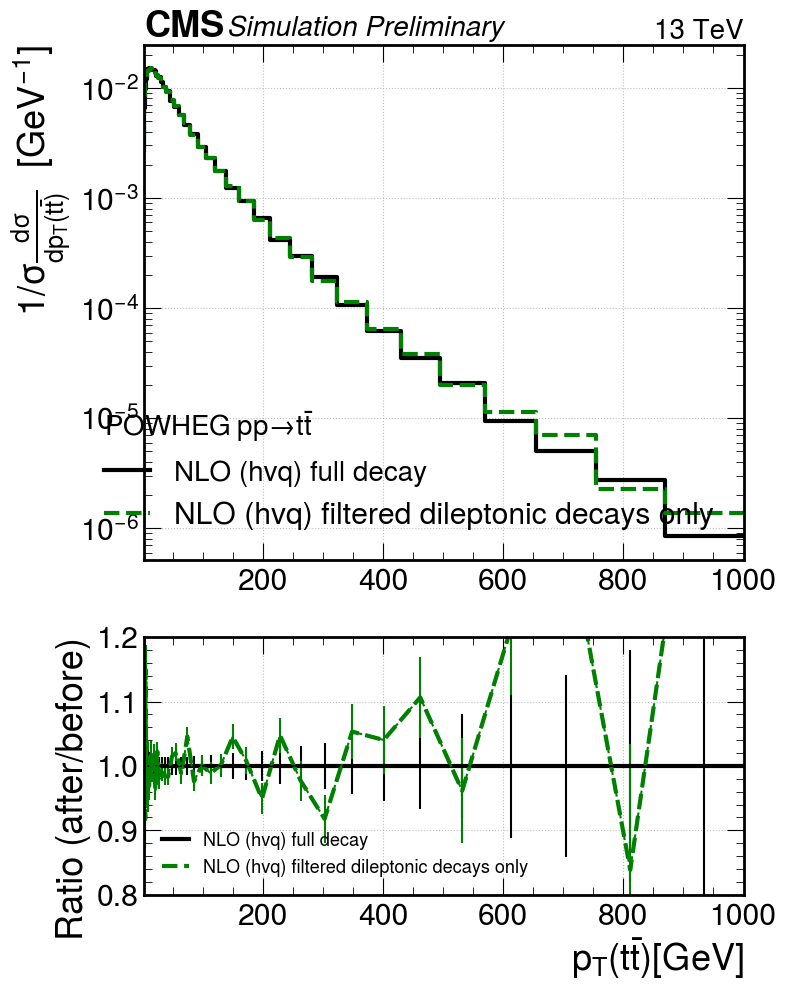

/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1781: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1782: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


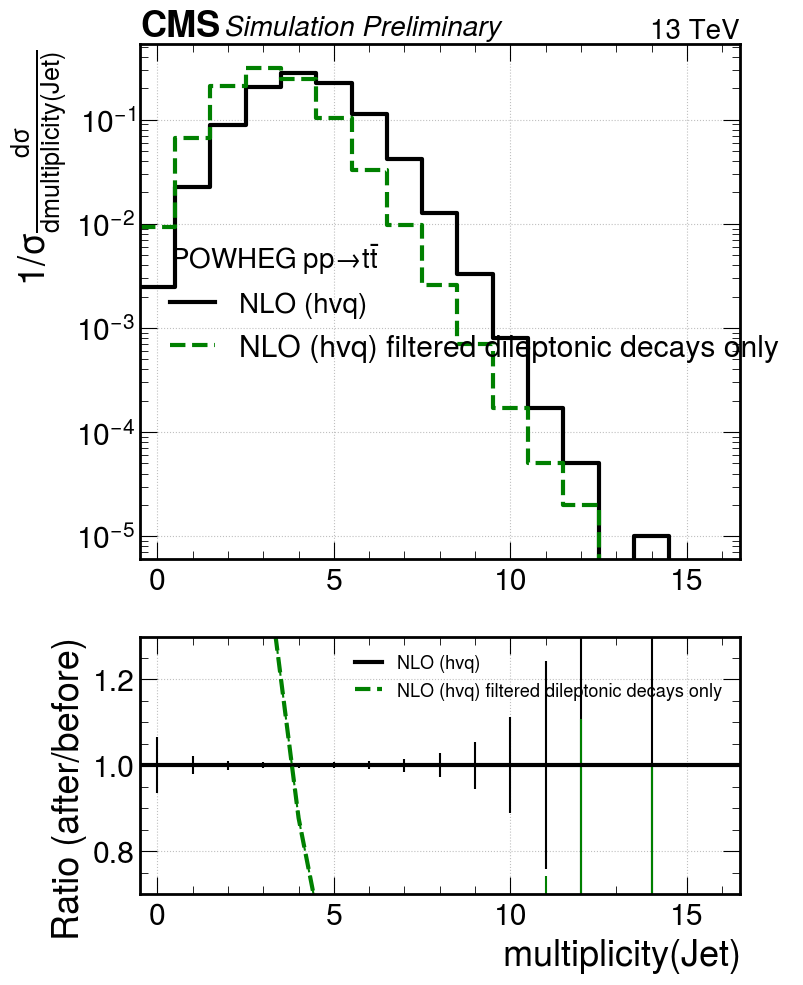

In [30]:
# compare filtered and unfiltered hvq

args = [(X0_showered, X0_wgt, 'NLO (hvq) full decay'),
        (X0_filtered_showered, X0_filtered_wgt, 'NLO (hvq) filtered dileptonic decays only')]


log_bins = np.logspace(np.log10(1), np.log10(1000), 50)


DCTR.plot_ratio_cms_2(args, bins = log_bins, y_scale = 'log', ratio_ylim=[0.8, 1.2]) #, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')




args_multiplicity = [(X0_nJets[:,0], X0_wgt, 'NLO (hvq)'),
                     (X0_filtered_nJets[:,0], X0_filtered_wgt, 'NLO (hvq) filtered dileptonic decays only')]

bins = np.linspace(-0.5, 16.5, 18)


DCTR.plot_ratio_cms_2(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


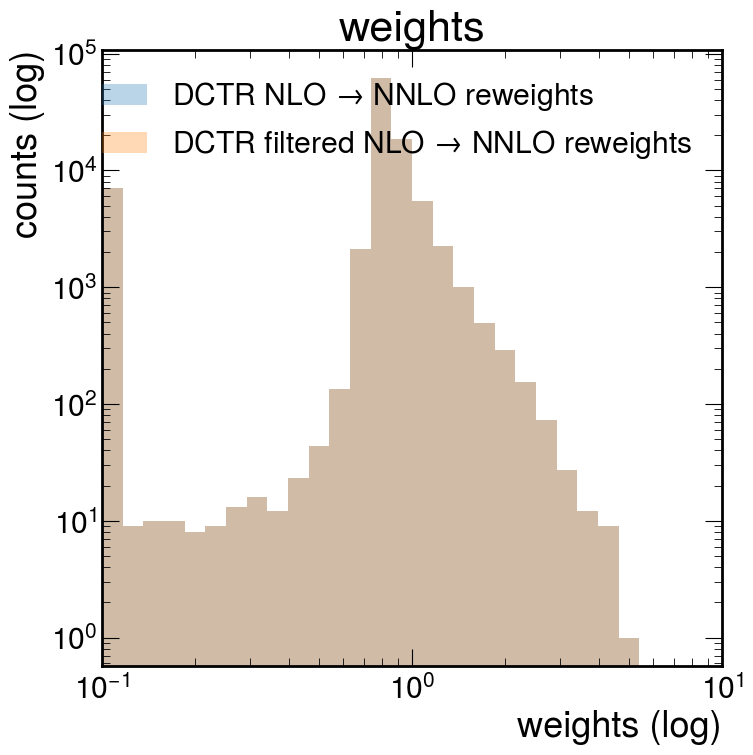

In [33]:
# calculate weights from DCTR
model = '../20240521_showered_new/train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder)) for showered events

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
    dctr_rwgt_filtered = DCTR.get_rwgt([model], X0_filtered_nrm)


wgts_plot = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights'), 
             (dctr_rwgt_filtered[0], r'DCTR filtered NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts_plot, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)
rwgt_filtered = np.multiply(dctr_rwgt_filtered[0], X0_filtered_wgt)


In [8]:
print(X1_wgt)
print(X0_wgt)

print(rwgt)


[103.245 103.245 103.245 ... 103.245 103.245 103.245]
[692.328 692.328 692.328 ... 692.328 692.328 692.328]
[543.38724949 549.3811721  573.67865454 ... 518.45142385 614.86497573
 723.83382111]


In [9]:
print(np.shape(X1_nJets))
print(np.shape(X1_wgt))

print(np.shape(X0_nJets))
print(np.shape(X0_wgt))

print(np.shape(rwgt))

(10000, 2)
(10000,)
(10000, 2)
(10000,)
(10000,)


# jet multiplicity


/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1393: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1394: RuntimeWarning: divide by zero encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1394: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1395: RuntimeWarning: divide by zero encountered in true_divide
  ratio_2 = hist2 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1395: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font wi

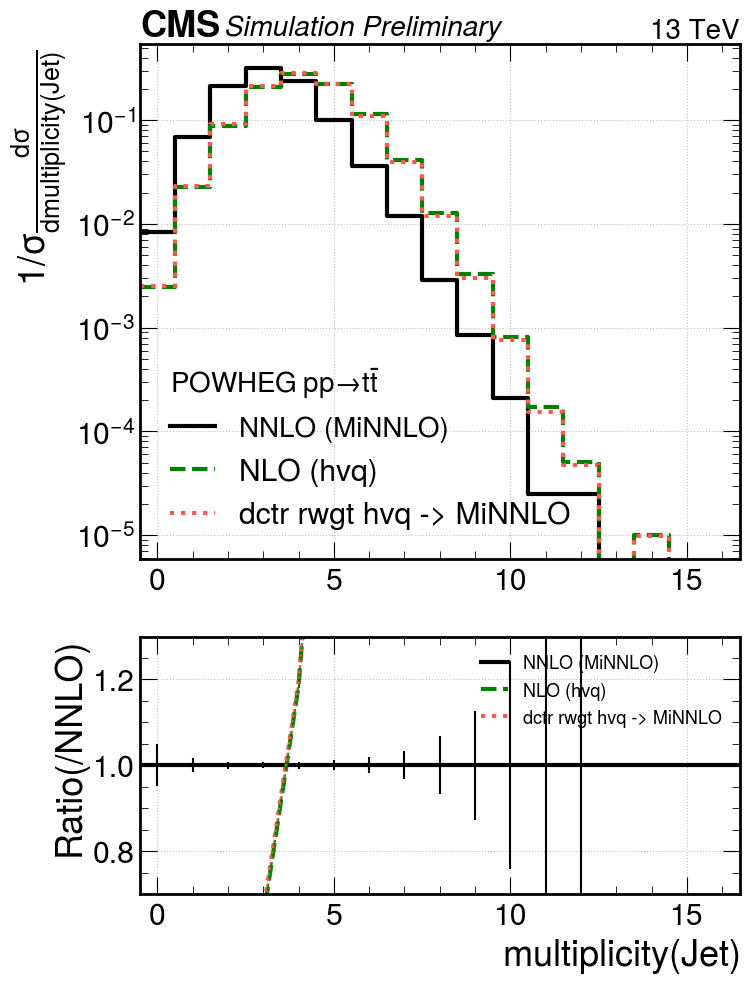

/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1393: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1394: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1395: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


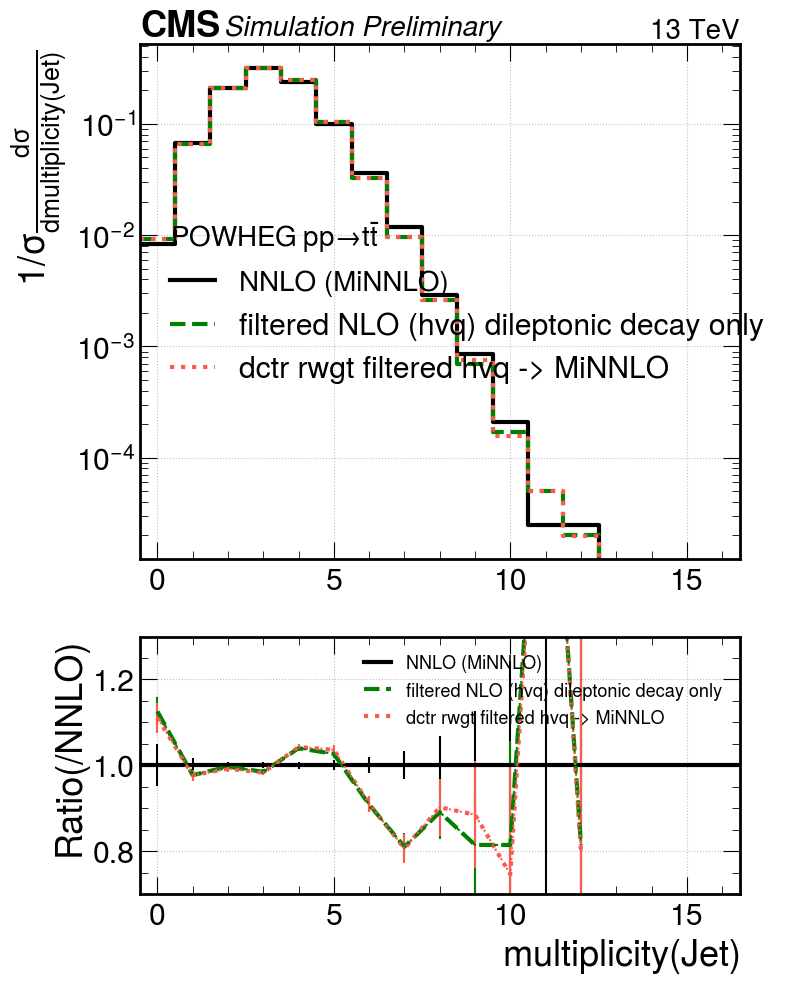

In [39]:
args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nJets[:,0], X0_wgt, 'NLO (hvq)'),
                     (X0_nJets[:,0], rwgt, 'dctr rwgt hvq -> MiNNLO')]


bins = np.linspace(-0.5, 16.5, 18)


DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


args_multiplicity_filtered = [(X1_nJets[:,0], X1_wgt, 'NNLO (MiNNLO)'),
                              (X0_filtered_nJets[:,0], X0_filtered_wgt, 'filtered NLO (hvq) dileptonic decay only'),
                              (X0_filtered_nJets[:,0], rwgt_filtered, 'dctr rwgt filtered hvq -> MiNNLO')]


DCTR.plot_ratio_cms(args_multiplicity_filtered, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


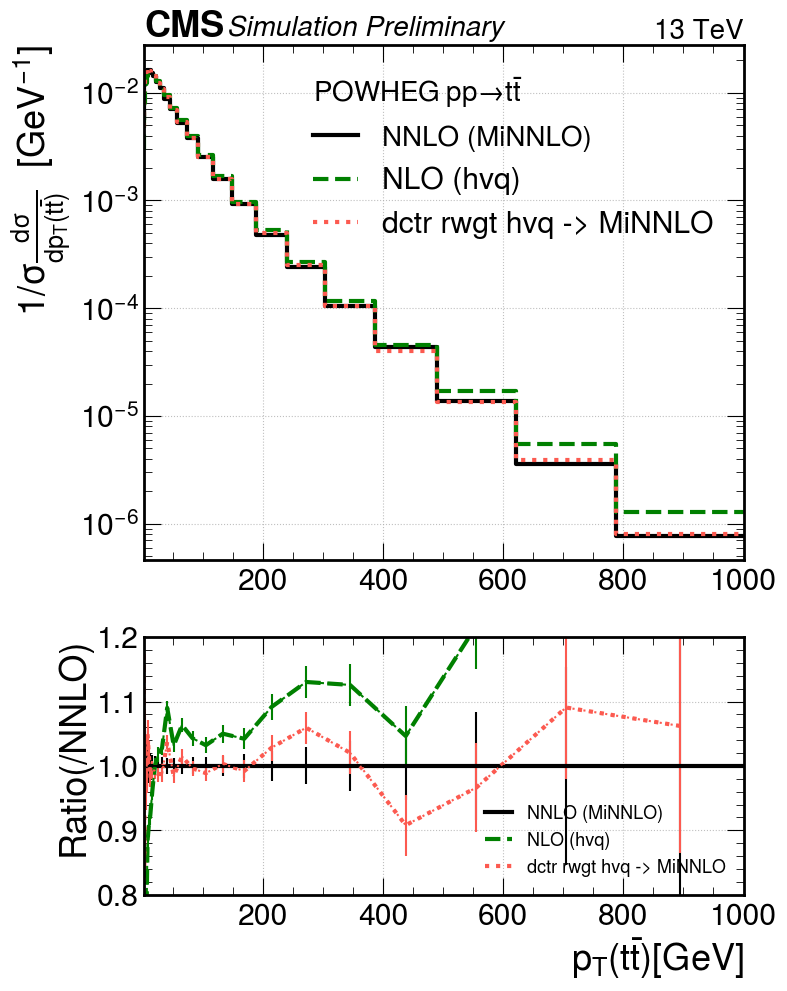

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


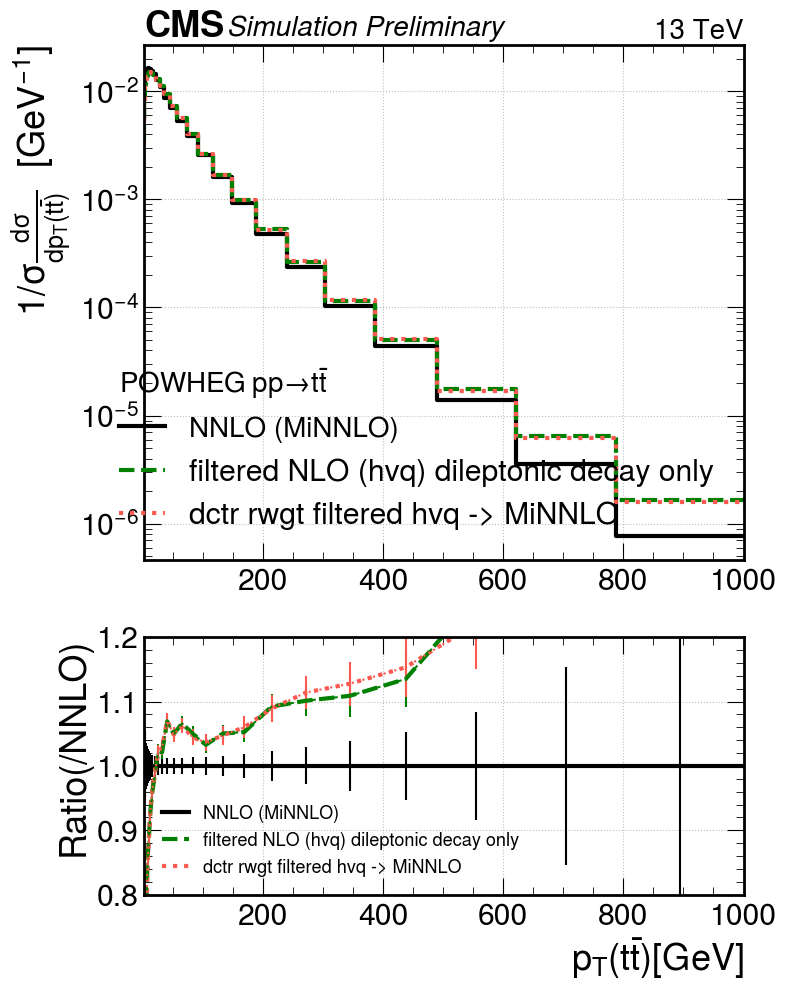

In [50]:
args = [(X1_showered, X1_wgt, 'NNLO (MiNNLO)'),
        (X0_showered, X0_wgt, 'NLO (hvq)'),
        (X0_showered, rwgt, 'dctr rwgt hvq -> MiNNLO')]


log_bins = np.logspace(np.log10(1), np.log10(1000), 30)


DCTR.plot_ratio_cms(args, bins = log_bins, y_scale = 'log', ratio_ylim=[0.8, 1.2]) #, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


args_filtered = [(X1_showered, X1_wgt, 'NNLO (MiNNLO)'),
                 (X0_filtered_showered, X0_filtered_wgt, 'filtered NLO (hvq) dileptonic decay only'),
                 (X0_filtered_showered, rwgt_filtered, 'dctr rwgt filtered hvq -> MiNNLO')]

DCTR.plot_ratio_cms(args_filtered, bins = log_bins, y_scale = 'log', ratio_ylim=[0.8, 1.2]) #, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


# jet p_t

In [ ]:
log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1. Jet', ratio_ylim=(0.7, 1.3))


args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2. Jet')


args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3. Jet')


args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4. Jet')


In [ ]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')

log_bins = np.logspace(np.log10(10), np.log10(1000), 31)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), rwgt, 'dctr reweighted')]

log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.7, 1.3))


